In [2]:
#import packages
import time
import numpy as np
import capytaine as cpt
import scipy
from capytaine.io.mesh_writers import write_STL
import matplotlib.pyplot as plt
from scipy.linalg import block_diag
import logging
import xarray as xr
from capytaine.io.xarray import merge_complex_values
from capytaine.post_pro import rao
logging.basicConfig(level=logging.INFO, format='%(levelname)-8s: %(message)s')
import scienceplots
plt.style.use(['science','no-latex','ieee'])

# Import custom package
import DM_Assemble as DM_A
import DM_Reading  as DM_R
import DM_ShowNodes as DMshow
import DM_Verify as DM_V
import DM_Windload as DM_Wind
from wave_spectrum import  jonswap

In [ ]:
# Show nodes
file_path = "data\model300_60\Job-22.inp"
label_interval = 10
elements = DMshow.plot_fea_model(file_path, label_interval)

In [ ]:
len(elements)

In [ ]:
dataset = DM_V.verify_hydrodynamic_data("data\Windcase_data\DM10_0.2L_value_1.0134.nc",wave_direction=0)

In [ ]:
dataset['wavelength'].values

In [ ]:
# check wave excitation_force
plt.plot(abs(dataset['excitation_force'][0][0][2::6]))

In [ ]:
# main 
if __name__ == "__main__":
    N = 4681   # Suppose the number of nodes is 793 63,2*2 model 4681 151

    # Obtain the dataset
    dataset = merge_complex_values(xr.open_dataset("data\Windcase_data\DM10_0.2L_value_1.0134.nc")) # << Change
    # Here we use 1.0 as an example, in actual applications you should use your real data
    omega = 1.0134  #<<<<<<<< Change

    # Obtain the structural stiffness matrix
    file_path = "data\model300_60\stifness22.mtx"  # Replace with your file path

    # Extract matrices and force from the dataset
    added_mass = dataset['added_mass'][0].values
    radiation_damping = dataset['radiation_damping'][0].values
    inertia_matrix = dataset['inertia_matrix'].values
    hydrostatic_stiffness = dataset['hydrostatic_stiffness'].values
    F_w = dataset['Froude_Krylov_force'][0].values + dataset['diffraction_force'][0].values
    
    # Construct the combined matrices
    M = added_mass + inertia_matrix  # Total mass
    C = radiation_damping  # Damping
    K = hydrostatic_stiffness  # Stiffness
    
    # Sample node ID list
    # node_ids = [41, 39, 37, 35, 33, 31, 29, 27, 25, 23]
    node_ids = DM_A.calculate_node_positions(2409,15,10)
    print(node_ids)
    
    # Assemble the matrices
    mass = DM_A.insert_matrix(N, M, node_ids)
    damping = DM_A.insert_matrix(N, C, node_ids)
    hy_stiffness = DM_A.insert_matrix(N, K, node_ids)
    stiffness = DM_R.get_stiffness_matrix(file_path) + hy_stiffness
    # Assemble the force matrix
    K_F_w = DM_A.extend_force_matrix(F_w, node_ids, N)*np.sqrt(2*jonswap(4.3,9,2,0.648)*0.1) # <<<<<<< Change
    # Consider wind load
    windload_cd = DM_Wind.WindLoad(U10=14.3, z=3, total_rows=31, total_cols=151, file_path="winddata\Ti0.1_cd_degree0.txt")
    windload_cl = DM_Wind.WindLoad(U10=14.3, z=3, total_rows=31, total_cols=151, file_path="winddata\Ti0.1_cl_degree0.txt")
    # represent wind frequency 0.01, dof represent the position of force
    # Wind_Force = windload_cd.compute_wind_force(0.01, dof=0) + windload_cl.compute_wind_force(0.01, dof=2)
    Wind_Damping = windload_cd.compute_wind_damping(dof=0) + windload_cl.compute_wind_damping(dof=2) + windload_cd.compute_wind_damping(dof=5)*1

    # 开始计时
    start_time = time.time()
    X = DM_A.solve_frequency_domain(mass, damping+Wind_Damping, stiffness, K_F_w, omega)  # Solve in frequency domain
    end_time = time.time()
    # 计算运行时间
    runtime = end_time - start_time
    # 打印运行时间
    print(f"代码的运行时间为: {runtime} 秒") 



In [ ]:
np.save("data\model300_60\X22.npy",X)

In [ ]:
np.sqrt(2*jonswap(4.3,9,2,0.648)*0.1)

In [ ]:
abs(Wind_Force.max())
abs(K_F_w.max()*0.7)

In [ ]:
# forceAnalysis
from DM_forec_analysis import ForceAnalysis
analyzer = ForceAnalysis(N=793, H=13, module_nodes=7, module_number=10, element_length=5, element_width=5)

# Compute module displacements using the provided displacement matrix X
module_displacements = analyzer.compute_module_displacements(displacement_matrix=X)

# Fetch the stiffness matrix for an element from a specified file
K_element = DM_R.get_stiffness_matrix("winddata\sub_m10_w60.mtx")

# Compute forces within the module using the stiffness matrix and module displacements
module_forces = analyzer.compute_module_forces(K_element, module_displacements)

# Map the forces from module level to global nodes
global_forces = analyzer.map_forces_to_global_nodes(module_forces)

# Visualize global forces using a plot
analyzer.plot_forces(global_forces)

M = analyzer.get_middle_interface_forces(global_forces)
# # Display global forces as a 2D heatmap
# analyzer.plot_2D_heatmap(global_forces)

# # Display global forces as a 3D surface plot
# analyzer.plot_3D_surface(global_forces)

In [ ]:
# Show heave displacement
import matplotlib.pyplot as plt
displacement = X
# 提取中轴线上的节点位移
mid_axis_nodes_start = 151*16-150  # 起始节点
mid_axis_nodes_end = 151*16 # 结束节点

# 由于每个节点有6个自由度，我们需要找到与这些节点对应的位移
mid_axis_displacement = displacement[(mid_axis_nodes_start-1)*6:(mid_axis_nodes_end)*6:6, :]

# 垂荡位移应该是Y轴（第2个自由度）的位移，我们需要每6个自由度取一次
heave_displacement = displacement[(mid_axis_nodes_start-1)*6+2:(mid_axis_nodes_end)*6:6, :]

# 定义节点在长度方向上的位置
length = np.linspace(0, 300, mid_axis_nodes_end-mid_axis_nodes_start+1)

# 绘制位移曲线
plt.figure(figsize=(10, 6))
plt.plot(length, np.abs(heave_displacement[::-1]), marker='o')  # 绘制垂荡位移的绝对值
plt.xlabel("Length (m)", fontsize=12)
plt.ylabel("Heave displacement", fontsize=12)
plt.title("Heave displacement along the length", fontsize=14)
plt.grid(True)
plt.show()


In [ ]:
O = np.linspace(0.01,2,100)
S = jonswap(12.19,14,2.5,O)
plt.plot(O,S)

In [ ]:
f_wind = Wind_Force[0,2::6].reshape(31,151)

In [ ]:
plt.plot(abs(f_wind[10]))

In [ ]:
windload_cd = DM_Wind.WindLoad(U10=14.3, z=3, total_rows=31, total_cols=151, file_path="winddata\Ti0.1_cd_degree0.txt")
windload_cl = DM_Wind.WindLoad(U10=14.3, z=3, total_rows=31, total_cols=151, file_path="winddata\Ti0.1_cl_degree0.txt")

In [ ]:
windload_cl.adjust_wind_speed()

In [ ]:
U10 = 14.3
z = np.linspace(0.00001,10,100)
wind_speed = U10*(z/10)**0.125

In [ ]:
plt.ylabel(r"z ($m$)")
plt.xlabel(r"Wind speed ($m$/$s$)")
plt.plot(wind_speed,z)

In [ ]:
DM_A.calculate_2d_node_positions_descending(3921,10,151,3,15)[15:30]

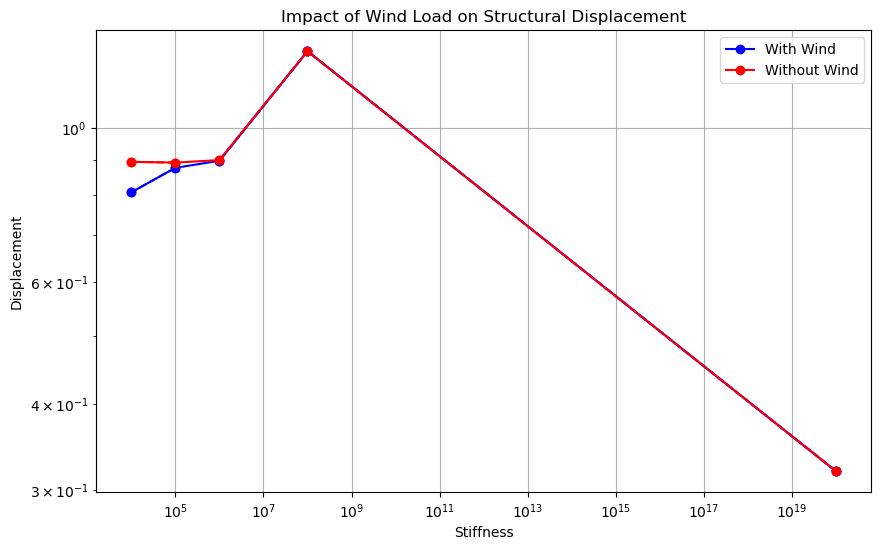

In [2]:
stiffnesses = [1.00e+04, 1.00e+05, 1.00e+06, 1.00e+08, 1.00e+20]
displacements_with_wind = [0.807776989, 0.876108374, 0.896916675, 1.291567589, 0.319529924]
displacements_without_wind = [0.893713533, 0.891502908, 0.898955107, 1.290951058, 0.319529924]
import matplotlib.pyplot as plt
import numpy as np

# 数据
stiffnesses = np.array([1.00e+04, 1.00e+05, 1.00e+06, 1.00e+08, 1.00e+20])[::-1]
displacements_with_wind = np.array([0.807776989, 0.876108374, 0.896916675, 1.291567589, 0.319529924])
displacements_without_wind = np.array([0.893713533, 0.891502908, 0.898955107, 1.290951058, 0.319529924])

# 绘图
plt.figure(figsize=(10, 6))
plt.loglog(stiffnesses, displacements_with_wind, 'o-', label='With Wind', color='blue')
plt.loglog(stiffnesses, displacements_without_wind, 'o-', label='Without Wind', color='red')

# 添加虚线趋势
plt.loglog(stiffnesses[:3], displacements_with_wind[:3], 'o--', color='blue')
plt.loglog(stiffnesses[3:], displacements_with_wind[3:], 'o--', color='blue')
plt.loglog(stiffnesses[:3], displacements_without_wind[:3], 'o--', color='red')
plt.loglog(stiffnesses[3:], displacements_without_wind[3:], 'o--', color='red')

plt.xlabel('Stiffness')
plt.ylabel('Displacement')
plt.title('Impact of Wind Load on Structural Displacement')
plt.legend()
plt.grid(True)
plt.show()


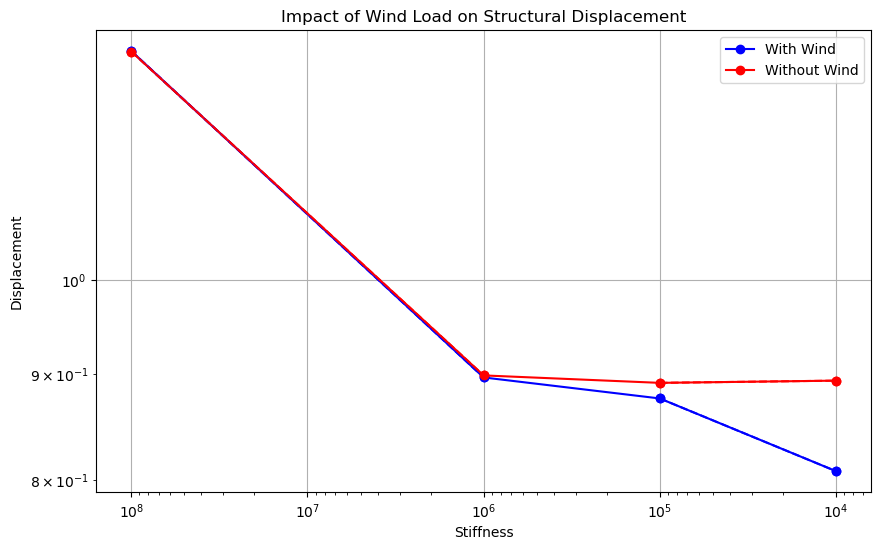

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# 数据
stiffnesses = np.array([1.00e+08, 1.00e+06, 1.00e+05, 1.00e+04])
displacements_with_wind = np.array([1.291567589, 0.896916675, 0.876108374, 0.807776989])
displacements_without_wind = np.array([1.290951058, 0.898955107, 0.891502908, 0.893713533])

# 绘图
plt.figure(figsize=(10, 6))
plt.loglog(stiffnesses, displacements_with_wind, 'o-', label='With Wind', color='blue')
plt.loglog(stiffnesses, displacements_without_wind, 'o-', label='Without Wind', color='red')

# 添加虚线趋势
plt.loglog(stiffnesses[:2], displacements_with_wind[:2], 'o--', color='blue')
plt.loglog(stiffnesses[-2:], displacements_with_wind[-2:], 'o--', color='blue')
plt.loglog(stiffnesses[:2], displacements_without_wind[:2], 'o--', color='red')
plt.loglog(stiffnesses[-2:], displacements_without_wind[-2:], 'o--', color='red')

plt.xlabel('Stiffness')
plt.ylabel('Displacement')
plt.title('Impact of Wind Load on Structural Displacement')
plt.legend()
plt.grid(True)
plt.gca().invert_xaxis()  # 反转x轴
plt.show()


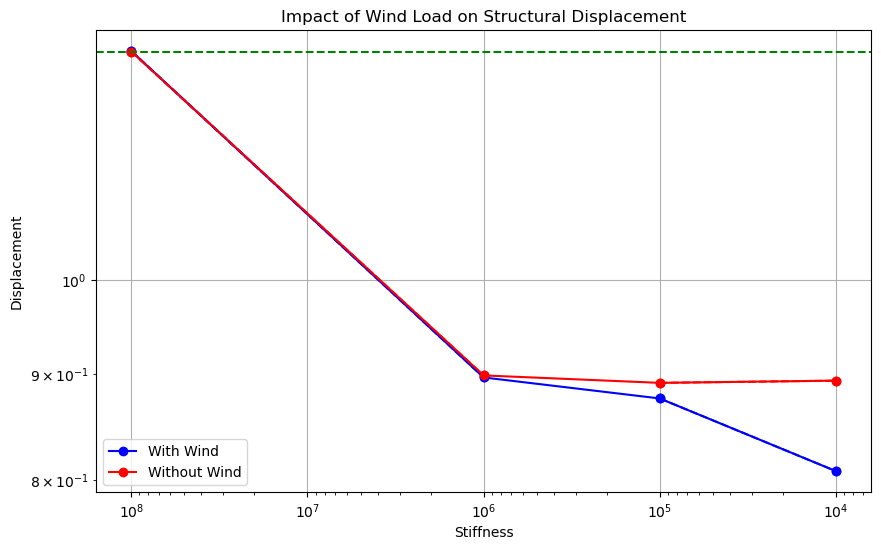

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# 数据
stiffnesses = np.array([1.00e+08, 1.00e+06, 1.00e+05, 1.00e+04])
displacements_with_wind = np.array([1.291567589, 0.896916675, 0.876108374, 0.807776989])
displacements_without_wind = np.array([1.290951058, 0.898955107, 0.891502908, 0.893713533])

# 绘图
plt.figure(figsize=(10, 6))
plt.loglog(stiffnesses, displacements_with_wind, 'o-', label='With Wind', color='blue')
plt.loglog(stiffnesses, displacements_without_wind, 'o-', label='Without Wind', color='red')

# 添加虚线趋势
plt.loglog(stiffnesses[:2], displacements_with_wind[:2], 'o--', color='blue')
plt.loglog(stiffnesses[-2:], displacements_with_wind[-2:], 'o--', color='blue')
plt.loglog(stiffnesses[:2], displacements_without_wind[:2], 'o--', color='red')
plt.loglog(stiffnesses[-2:], displacements_without_wind[-2:], 'o--', color='red')

# 添加恒定数值的虚线
constant_displacement = 1.29  # 假设的恒定位移值
plt.axhline(y=constant_displacement, color='green', linestyle='--')

plt.xlabel('Stiffness')
plt.ylabel('Displacement')
plt.title('Impact of Wind Load on Structural Displacement')
plt.legend()
plt.grid(True)
plt.gca().invert_xaxis()  # 反转x轴
plt.show()
